This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./input/test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

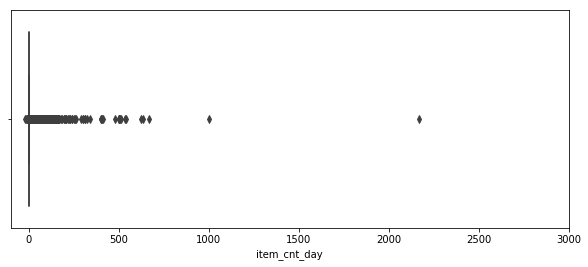

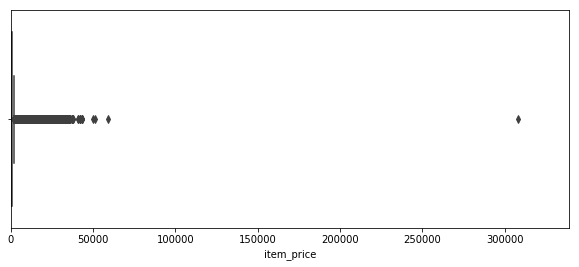

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train.shape

(2935849, 6)

In [5]:
train[0:100]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [7]:
train.shape

(2935847, 6)

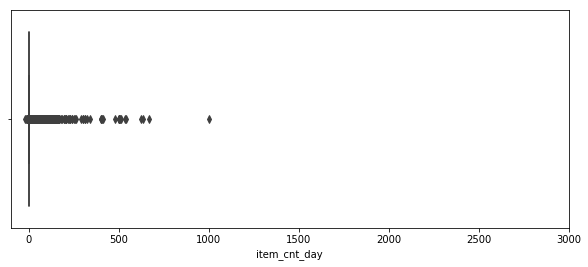

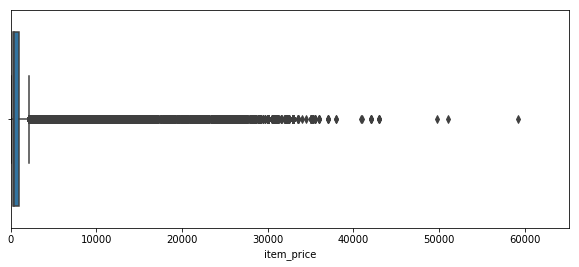

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

There is one item with price below zero. Fill it with median.

In [9]:
train.loc[train.item_cnt_day<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.00,-1.0
148,23.01.2013,0,25,2321,999.00,-1.0
175,07.01.2013,0,25,2199,1449.00,-1.0
807,02.01.2013,0,25,2330,599.00,-1.0
1041,13.01.2013,0,25,5034,1989.00,-1.0
1193,02.01.2013,0,25,5651,5490.00,-1.0
1674,07.01.2013,0,25,4093,899.00,-1.0
1825,02.01.2013,0,25,4249,1894.87,-1.0
2411,14.01.2013,0,24,1628,3899.00,-1.0
3216,08.01.2013,0,24,20948,899.00,-1.0


In [10]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [11]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
print("median:", median)
train.loc[train.item_price<0, 'item_price'] = median

median: 1874.0


Several shops are duplicates of each other (according to its name). Fix train and test set.

In [12]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [13]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [14]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"']

,shop_name,shop_id
46,"Сергиев Посад ТЦ ""7Я""",46


In [15]:
shops["shop_name"].str.split(' ').map(lambda x: x[0])

0              !Якутск
1              !Якутск
2               Адыгея
3             Балашиха
4             Волжский
5              Вологда
6              Воронеж
7              Воронеж
8              Воронеж
9             Выездная
10           Жуковский
11           Жуковский
12    Интернет-магазин
13              Казань
14              Казань
15              Калуга
16             Коломна
17          Красноярск
18          Красноярск
19               Курск
20              Москва
21              Москва
22              Москва
23              Москва
24              Москва
25              Москва
26              Москва
27              Москва
28              Москва
29              Москва
30              Москва
31              Москва
32              Москва
33              Мытищи
34          Н.Новгород
35          Н.Новгород
36         Новосибирск
37         Новосибирск
38                Омск
39        РостовНаДону
40        РостовНаДону
41        РостовНаДону
42                 СПб
43         

In [16]:
LabelEncoder().fit_transform(["abc","def","ghi","abc"])

array([0, 1, 2, 0], dtype=int64)

In [17]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [18]:
items

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
5,5,40
6,6,40
7,7,40
8,8,40
9,9,40


## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [19]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [20]:
np.vstack(np.array(list(product([0],[0,1],[0,1]))))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1]])

In [21]:
train.date_block_num.unique().shape

(34,)

In [22]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

11.427422523498535

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [23]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [24]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

5.154033899307251

## Test set
To use time tricks append test pairs to the matrix.

In [25]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [26]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.11093807220458984

## Shops/Items/Cats features

In [27]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

5.980556488037109

## Target lags

In [28]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [29]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

34.722017765045166

In [30]:
matrix[matrix.date_block_num == 13]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
4836056,13,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0
4836057,13,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,4.0
4836058,13,2,32,0.0,0,40,11,4,1.0,0.0,0.0,0.0,0.0
4836059,13,2,33,0.0,0,37,11,1,1.0,1.0,2.0,0.0,0.0
4836060,13,2,34,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0
4836061,13,2,36,0.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0
4836062,13,2,37,0.0,0,40,11,4,0.0,0.0,0.0,0.0,NaN
4836063,13,2,40,0.0,0,57,13,8,0.0,0.0,0.0,0.0,0.0
4836064,13,2,42,0.0,0,57,13,8,0.0,0.0,0.0,0.0,0.0
4836065,13,2,44,0.0,0,57,13,8,0.0,0.0,0.0,0.0,0.0


## Mean encoded features

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.358463764190674

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

42.265676975250244

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

46.89601159095764

In [34]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.334174871444702

In [35]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.08474349975586

In [36]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.318607568740845

In [37]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.968505382537842

In [38]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.074616193771362

In [39]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.631398916244507

In [40]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.474368810653687

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.547483921051025

In [42]:
dir()

['In',
 'LabelEncoder',
 'Out',
 'XGBRegressor',
 '_',
 '_1',
 '_10',
 '_12',
 '_14',
 '_15',
 '_16',
 '_18',
 '_19',
 '_20',
 '_21',
 '_22',
 '_24',
 '_26',
 '_27',
 '_29',
 '_3',
 '_30',
 '_31',
 '_32',
 '_33',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_4',
 '_40',
 '_41',
 '_5',
 '_7',
 '_8',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'cats',
 'cols',
 'exit',
 'gc',
 'get_ipython',
 'group',
 'i',
 'items',
 'lag_feature',
 'matrix',
 'median',
 'np',
 'pd',
 'pickle',
 'plot_features

## Trend features

Price trend for the last six months.

In [43]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

MemoryError: 

Last month shop revenue trend

In [ ]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

## Special features

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

In [ ]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [ ]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del data
gc.collect();

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
plot_features(model, (10,14))